In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
a = 32
b = 96
seg_len = 128
num = 500

In [4]:
idxs = torch.randint(a, b, (num, ))

In [5]:
all_data = []
all_labels = []

for idx in idxs:
    mu = torch.randint(3, 100, (1, ))
    x1 = torch.normal(1, 2., size=(seg_len,))
    x2 = torch.normal(float(mu[0]), 2., size=(seg_len,))
    x = torch.cat([x1[:idx], x2[idx:]])
    
    label = torch.cat([torch.zeros(idx), torch.ones(seg_len-idx)])
    
    all_data.append(x)
    all_labels.append(label)
    
    all_data.append(x1[:seg_len])    
    all_labels.append(torch.zeros(seg_len))

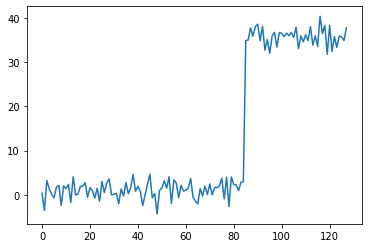

In [6]:
plt.plot(all_data[4])

In [7]:
all_data = np.vstack(all_data)
all_labels = np.vstack(all_labels)

In [8]:
all_data.shape

(1000, 128)

In [9]:
seg_len

128

In [10]:
all_data = all_data.reshape(2*num, seg_len, 1)

In [11]:
import os
SEQ_LEN = seg_len
IM_SIZE = 1

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.2, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

In [13]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(800, 128, 1)
(100, 128, 1)
(100, 128, 1)


In [14]:
!nvidia-smi

Thu May 27 09:00:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 75%   86C    P2   142W / 280W |  12901MiB / 24219MiB |     17%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 53%   75C    P2   141W / 280W |  18702MiB / 24220MiB |     49%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0')

In [16]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [17]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [18]:
# input data parameters
input_size = 1
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 8
n_layers = 1
num_workers = 1
learning_rate = 1e-3
drop_prob = 0.1

batch_size = 16

In [19]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [20]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [21]:
def train_model(model, loss_function, epochs=100, print_every=30, LSTM_flag=False, RNN_flag=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            elif RNN_flag:
                #h = model.init_hidden(batch_size)
                #h = torch.stack([e.data for e in h])
                h = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
                output, h = model(inputs, h)                
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    elif RNN_flag:
                        #val_h = model.init_hidden(batch_size)
                        #val_h = torch.stack([each.data for each in val_h])
                        val_h = torch.zeros(n_layers, batch_size, hidden_dim).to(device)
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [22]:
!rm -rf experiments3
!mkdir experiments3

### LSTM Model

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        #self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, 1)
        #self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        #self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        #out = self.dropout(out)
        #out = self.relu(out)
        #out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [24]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, 
                         n_layers=n_layers, drop_prob=drop_prob)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(1, 8, batch_first=True, dropout=0.1)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [25]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 25, 5, LSTM_flag=True)

model_LSTM_custom = model_LSTM_custom.eval() 
torch.save(model_LSTM_custom, "experiments3/model_LSTM_custom.pth")

Epoch: 1/25... Step: 5... Loss: -2.483225... Val Loss: -2.620448
Epoch: 1/25... Step: 10... Loss: -3.865482... Val Loss: -2.568928
Epoch: 1/25... Step: 15... Loss: -2.777848... Val Loss: -2.570729
Epoch: 1/25... Step: 20... Loss: -2.253354... Val Loss: -2.639569
Epoch: 1/25... Step: 25... Loss: -3.698320... Val Loss: -2.868235
Epoch: 1/25... Step: 30... Loss: -3.950262... Val Loss: -3.002497
Epoch: 1/25... Step: 35... Loss: -2.544952... Val Loss: -2.928068
Epoch: 1/25... Step: 40... Loss: -2.784629... Val Loss: -3.010496
Epoch: 1/25... Step: 45... Loss: -2.630642... Val Loss: -3.261604
Epoch: 1/25... Step: 50... Loss: -2.904791... Val Loss: -3.193084
Epoch: 2/25... Step: 55... Loss: -2.523112... Val Loss: -3.208226
Epoch: 2/25... Step: 60... Loss: -4.050785... Val Loss: -3.288530
Epoch: 2/25... Step: 65... Loss: -2.289772... Val Loss: -3.419181
Epoch: 2/25... Step: 70... Loss: -2.420859... Val Loss: -3.329477
Epoch: 2/25... Step: 75... Loss: -4.211921... Val Loss: -3.316267
Epoch: 2/25

Epoch: 13/25... Step: 605... Loss: -18.310638... Val Loss: -20.645818
Epoch: 13/25... Step: 610... Loss: -26.277905... Val Loss: -21.433999
Epoch: 13/25... Step: 615... Loss: -13.234780... Val Loss: -22.587178
Epoch: 13/25... Step: 620... Loss: -22.852240... Val Loss: -18.951295
Epoch: 13/25... Step: 625... Loss: -9.656912... Val Loss: -16.612128
Epoch: 13/25... Step: 630... Loss: -16.924923... Val Loss: -20.762635
Epoch: 13/25... Step: 635... Loss: -15.757392... Val Loss: -20.608768
Epoch: 13/25... Step: 640... Loss: -17.511250... Val Loss: -20.067445
Epoch: 13/25... Step: 645... Loss: -28.792618... Val Loss: -20.385156
Epoch: 13/25... Step: 650... Loss: -21.424488... Val Loss: -19.521121
Epoch: 14/25... Step: 655... Loss: -19.803230... Val Loss: -21.611216
Epoch: 14/25... Step: 660... Loss: -25.870230... Val Loss: -21.523835
Epoch: 14/25... Step: 665... Loss: -13.183055... Val Loss: -23.387633
Epoch: 14/25... Step: 670... Loss: -28.602238... Val Loss: -22.265285
Epoch: 14/25... Step:

Epoch: 24/25... Step: 1190... Loss: -15.667292... Val Loss: -24.148323
Epoch: 24/25... Step: 1195... Loss: -18.289150... Val Loss: -25.812719
Epoch: 24/25... Step: 1200... Loss: -30.448908... Val Loss: -24.761793
Epoch: 25/25... Step: 1205... Loss: -17.026171... Val Loss: -24.602400
Epoch: 25/25... Step: 1210... Loss: -32.894367... Val Loss: -26.512256
Epoch: 25/25... Step: 1215... Loss: -29.302757... Val Loss: -24.151627
Epoch: 25/25... Step: 1220... Loss: -26.002991... Val Loss: -25.610135
Epoch: 25/25... Step: 1225... Loss: -33.095478... Val Loss: -24.655800
Epoch: 25/25... Step: 1230... Loss: -25.474871... Val Loss: -25.779613
Epoch: 25/25... Step: 1235... Loss: -23.181900... Val Loss: -25.784722
Epoch: 25/25... Step: 1240... Loss: -31.495121... Val Loss: -26.816996
Epoch: 25/25... Step: 1245... Loss: -36.446457... Val Loss: -23.326676
Epoch: 25/25... Step: 1250... Loss: -23.814051... Val Loss: -22.624020


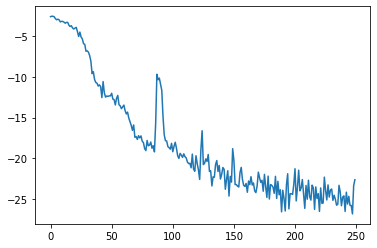

In [26]:
plt.plot(overall_val_loss_list)

In [27]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim,
                      n_layers=n_layers, drop_prob=drop_prob)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(1, 8, batch_first=True, dropout=0.1)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [28]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       25, 5, LSTM_flag=True)
model_LSTM_bce = model_LSTM_bce.eval()
torch.save(model_LSTM_bce, "experiments3/model_LSTM_bce.pth")

Epoch: 1/25... Step: 5... Loss: 0.670042... Val Loss: 0.670751
Epoch: 1/25... Step: 10... Loss: 0.687206... Val Loss: 0.659190
Epoch: 1/25... Step: 15... Loss: 0.657663... Val Loss: 0.650637
Epoch: 1/25... Step: 20... Loss: 0.654394... Val Loss: 0.639281
Epoch: 1/25... Step: 25... Loss: 0.626233... Val Loss: 0.626167
Epoch: 1/25... Step: 30... Loss: 0.629391... Val Loss: 0.615912
Epoch: 1/25... Step: 35... Loss: 0.601153... Val Loss: 0.604878
Epoch: 1/25... Step: 40... Loss: 0.583746... Val Loss: 0.592340
Epoch: 1/25... Step: 45... Loss: 0.581316... Val Loss: 0.582169
Epoch: 1/25... Step: 50... Loss: 0.561228... Val Loss: 0.573260
Epoch: 2/25... Step: 55... Loss: 0.566357... Val Loss: 0.561327
Epoch: 2/25... Step: 60... Loss: 0.558079... Val Loss: 0.549348
Epoch: 2/25... Step: 65... Loss: 0.534465... Val Loss: 0.535260
Epoch: 2/25... Step: 70... Loss: 0.542316... Val Loss: 0.522816
Epoch: 2/25... Step: 75... Loss: 0.502608... Val Loss: 0.507686
Epoch: 2/25... Step: 80... Loss: 0.510001

Epoch: 13/25... Step: 635... Loss: 0.036589... Val Loss: 0.043901
Epoch: 13/25... Step: 640... Loss: 0.038579... Val Loss: 0.043814
Epoch: 13/25... Step: 645... Loss: 0.054932... Val Loss: 0.043250
Epoch: 13/25... Step: 650... Loss: 0.048896... Val Loss: 0.043177
Epoch: 14/25... Step: 655... Loss: 0.033080... Val Loss: 0.042085
Epoch: 14/25... Step: 660... Loss: 0.043198... Val Loss: 0.041981
Epoch: 14/25... Step: 665... Loss: 0.046535... Val Loss: 0.041984
Epoch: 14/25... Step: 670... Loss: 0.035153... Val Loss: 0.040522
Epoch: 14/25... Step: 675... Loss: 0.047799... Val Loss: 0.041324
Epoch: 14/25... Step: 680... Loss: 0.032117... Val Loss: 0.040947
Epoch: 14/25... Step: 685... Loss: 0.051847... Val Loss: 0.040056
Epoch: 14/25... Step: 690... Loss: 0.038196... Val Loss: 0.039548
Epoch: 14/25... Step: 695... Loss: 0.040991... Val Loss: 0.039230
Epoch: 14/25... Step: 700... Loss: 0.027909... Val Loss: 0.038601
Epoch: 15/25... Step: 705... Loss: 0.074398... Val Loss: 0.038297
Epoch: 15/

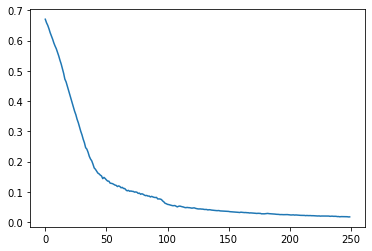

In [29]:
plt.plot(bce_overall_val_loss_list)

In [30]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(1, 8, batch_first=True, dropout=0.5)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [31]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, first_bce_loss_function, 15, 5, 
                                    LSTM_flag=True)

model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 10, 5, 
                                    LSTM_flag=True)


model_LSTM_combined = model_LSTM_combined.eval()
torch.save(model_LSTM_combined, "experiments3/model_LSTM_combined.pth")

Epoch: 1/15... Step: 5... Loss: 0.647710... Val Loss: 0.652737
Epoch: 1/15... Step: 10... Loss: 0.680135... Val Loss: 0.637917
Epoch: 1/15... Step: 15... Loss: 0.605427... Val Loss: 0.637683
Epoch: 1/15... Step: 20... Loss: 0.602966... Val Loss: 0.626393
Epoch: 1/15... Step: 25... Loss: 0.565772... Val Loss: 0.622026
Epoch: 1/15... Step: 30... Loss: 0.621580... Val Loss: 0.611669
Epoch: 1/15... Step: 35... Loss: 0.604447... Val Loss: 0.612008
Epoch: 1/15... Step: 40... Loss: 0.573758... Val Loss: 0.607838
Epoch: 1/15... Step: 45... Loss: 0.604851... Val Loss: 0.599789
Epoch: 1/15... Step: 50... Loss: 0.579789... Val Loss: 0.596541
Epoch: 2/15... Step: 55... Loss: 0.607054... Val Loss: 0.589033
Epoch: 2/15... Step: 60... Loss: 0.601748... Val Loss: 0.583569
Epoch: 2/15... Step: 65... Loss: 0.599111... Val Loss: 0.578251
Epoch: 2/15... Step: 70... Loss: 0.564412... Val Loss: 0.566698
Epoch: 2/15... Step: 75... Loss: 0.531116... Val Loss: 0.559798
Epoch: 2/15... Step: 80... Loss: 0.509034

Epoch: 13/15... Step: 635... Loss: 0.039522... Val Loss: 0.056830
Epoch: 13/15... Step: 640... Loss: 0.055234... Val Loss: 0.055982
Epoch: 13/15... Step: 645... Loss: 0.061097... Val Loss: 0.055616
Epoch: 13/15... Step: 650... Loss: 0.063092... Val Loss: 0.055654
Epoch: 14/15... Step: 655... Loss: 0.052742... Val Loss: 0.054139
Epoch: 14/15... Step: 660... Loss: 0.047012... Val Loss: 0.051336
Epoch: 14/15... Step: 665... Loss: 0.047554... Val Loss: 0.052493
Epoch: 14/15... Step: 670... Loss: 0.156678... Val Loss: 0.052452
Epoch: 14/15... Step: 675... Loss: 0.054316... Val Loss: 0.052981
Epoch: 14/15... Step: 680... Loss: 0.052845... Val Loss: 0.053065
Epoch: 14/15... Step: 685... Loss: 0.052741... Val Loss: 0.051335
Epoch: 14/15... Step: 690... Loss: 0.040414... Val Loss: 0.050662
Epoch: 14/15... Step: 695... Loss: 0.043715... Val Loss: 0.051493
Epoch: 14/15... Step: 700... Loss: 0.045951... Val Loss: 0.050294
Epoch: 15/15... Step: 705... Loss: 0.046232... Val Loss: 0.049944
Epoch: 15/

Epoch: 10/10... Step: 490... Loss: -20.280014... Val Loss: -18.724791
Epoch: 10/10... Step: 495... Loss: -15.082366... Val Loss: -19.748613
Epoch: 10/10... Step: 500... Loss: -20.532993... Val Loss: -19.739190


### GRU

In [35]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(GRU, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        #self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, 1)
        #self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        #self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        gru_out, hidden = self.gru(input_seq, hidden)  
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(gru_out)
        #out = self.dropout(out)
        #out = self.relu(out)
        #out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [36]:
model_GRU_custom = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, 
                       n_layers=n_layers, drop_prob=drop_prob)
loss_function = CustomLoss()
model_GRU_custom.to(device)

GRU(
  (gru): GRU(1, 8, batch_first=True, dropout=0.1)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [37]:
model_GRU_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_GRU_custom, loss_function, 25, 5, RNN_flag=True)

model_GRU_custom = model_GRU_custom.eval()
torch.save(model_GRU_custom, "experiments3/model_GRU_custom.pth")

Epoch: 1/25... Step: 5... Loss: -2.892900... Val Loss: -2.406415
Epoch: 1/25... Step: 10... Loss: -2.205279... Val Loss: -2.424397
Epoch: 1/25... Step: 15... Loss: -2.507437... Val Loss: -2.464404
Epoch: 1/25... Step: 20... Loss: -2.720602... Val Loss: -2.592874
Epoch: 1/25... Step: 25... Loss: -2.805763... Val Loss: -2.707351
Epoch: 1/25... Step: 30... Loss: -2.409550... Val Loss: -2.569419
Epoch: 1/25... Step: 35... Loss: -2.726291... Val Loss: -2.531308
Epoch: 1/25... Step: 40... Loss: -1.966061... Val Loss: -2.767922
Epoch: 1/25... Step: 45... Loss: -3.333916... Val Loss: -2.918806
Epoch: 1/25... Step: 50... Loss: -2.982177... Val Loss: -2.908527
Epoch: 2/25... Step: 55... Loss: -2.549359... Val Loss: -2.979550
Epoch: 2/25... Step: 60... Loss: -2.190799... Val Loss: -3.204949
Epoch: 2/25... Step: 65... Loss: -2.799770... Val Loss: -3.150632
Epoch: 2/25... Step: 70... Loss: -2.861518... Val Loss: -3.452945
Epoch: 2/25... Step: 75... Loss: -3.831231... Val Loss: -3.646504
Epoch: 2/25

Epoch: 13/25... Step: 605... Loss: -17.176386... Val Loss: -15.924099
Epoch: 13/25... Step: 610... Loss: -15.916498... Val Loss: -15.497060
Epoch: 13/25... Step: 615... Loss: -14.661312... Val Loss: -16.216425
Epoch: 13/25... Step: 620... Loss: -16.728111... Val Loss: -15.952727
Epoch: 13/25... Step: 625... Loss: -15.071367... Val Loss: -15.584668
Epoch: 13/25... Step: 630... Loss: -18.027365... Val Loss: -15.908292
Epoch: 13/25... Step: 635... Loss: -14.557990... Val Loss: -14.934745
Epoch: 13/25... Step: 640... Loss: -16.170139... Val Loss: -15.516675
Epoch: 13/25... Step: 645... Loss: -12.341972... Val Loss: -16.344809
Epoch: 13/25... Step: 650... Loss: -16.942110... Val Loss: -15.855514
Epoch: 14/25... Step: 655... Loss: -12.693659... Val Loss: -15.626038
Epoch: 14/25... Step: 660... Loss: -13.325316... Val Loss: -16.401571
Epoch: 14/25... Step: 665... Loss: -20.170126... Val Loss: -15.615920
Epoch: 14/25... Step: 670... Loss: -17.722826... Val Loss: -15.436373
Epoch: 14/25... Step

Epoch: 24/25... Step: 1190... Loss: -15.186109... Val Loss: -15.998391
Epoch: 24/25... Step: 1195... Loss: -16.874275... Val Loss: -15.551707
Epoch: 24/25... Step: 1200... Loss: -14.505743... Val Loss: -16.570178
Epoch: 25/25... Step: 1205... Loss: -16.697445... Val Loss: -16.418146
Epoch: 25/25... Step: 1210... Loss: -17.242405... Val Loss: -16.222554
Epoch: 25/25... Step: 1215... Loss: -15.395521... Val Loss: -17.254808
Epoch: 25/25... Step: 1220... Loss: -17.852253... Val Loss: -16.917916
Epoch: 25/25... Step: 1225... Loss: -23.421446... Val Loss: -16.878987
Epoch: 25/25... Step: 1230... Loss: -10.255140... Val Loss: -16.486783
Epoch: 25/25... Step: 1235... Loss: -11.611007... Val Loss: -16.223669
Epoch: 25/25... Step: 1240... Loss: -17.722706... Val Loss: -16.773357
Epoch: 25/25... Step: 1245... Loss: -18.087702... Val Loss: -16.798745
Epoch: 25/25... Step: 1250... Loss: -11.944735... Val Loss: -16.628435


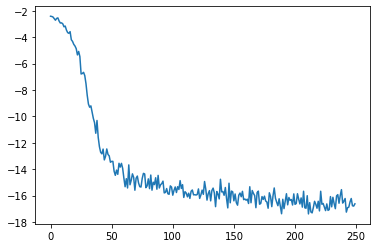

In [38]:
plt.plot(overall_val_loss_list)

In [39]:
model_GRU_bce = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, 
                    n_layers=n_layers, drop_prob=drop_prob)
bce_loss_function = torch.nn.BCELoss()
model_GRU_bce.to(device)

GRU(
  (gru): GRU(1, 8, batch_first=True, dropout=0.1)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [40]:
model_GRU_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_bce, bce_loss_function, 
                                                                                       25, 5, RNN_flag=True)

model_GRU_bce = model_GRU_bce.eval()
torch.save(model_GRU_bce, "experiments3/model_GRU_bce.pth")

Epoch: 1/25... Step: 5... Loss: 0.743465... Val Loss: 0.741091
Epoch: 1/25... Step: 10... Loss: 0.728286... Val Loss: 0.733908
Epoch: 1/25... Step: 15... Loss: 0.740799... Val Loss: 0.728222
Epoch: 1/25... Step: 20... Loss: 0.715309... Val Loss: 0.721030
Epoch: 1/25... Step: 25... Loss: 0.715067... Val Loss: 0.715037
Epoch: 1/25... Step: 30... Loss: 0.718182... Val Loss: 0.706638
Epoch: 1/25... Step: 35... Loss: 0.698815... Val Loss: 0.699306
Epoch: 1/25... Step: 40... Loss: 0.699692... Val Loss: 0.692627
Epoch: 1/25... Step: 45... Loss: 0.681583... Val Loss: 0.683313
Epoch: 1/25... Step: 50... Loss: 0.671615... Val Loss: 0.672128
Epoch: 2/25... Step: 55... Loss: 0.675024... Val Loss: 0.664894
Epoch: 2/25... Step: 60... Loss: 0.674918... Val Loss: 0.654363
Epoch: 2/25... Step: 65... Loss: 0.637248... Val Loss: 0.641622
Epoch: 2/25... Step: 70... Loss: 0.669698... Val Loss: 0.632147
Epoch: 2/25... Step: 75... Loss: 0.593191... Val Loss: 0.613762
Epoch: 2/25... Step: 80... Loss: 0.637406

Epoch: 13/25... Step: 635... Loss: 0.043532... Val Loss: 0.045198
Epoch: 13/25... Step: 640... Loss: 0.045044... Val Loss: 0.044801
Epoch: 13/25... Step: 645... Loss: 0.043502... Val Loss: 0.044211
Epoch: 13/25... Step: 650... Loss: 0.040912... Val Loss: 0.043626
Epoch: 14/25... Step: 655... Loss: 0.042858... Val Loss: 0.043201
Epoch: 14/25... Step: 660... Loss: 0.095412... Val Loss: 0.042904
Epoch: 14/25... Step: 665... Loss: 0.040437... Val Loss: 0.042402
Epoch: 14/25... Step: 670... Loss: 0.041802... Val Loss: 0.042024
Epoch: 14/25... Step: 675... Loss: 0.038545... Val Loss: 0.041528
Epoch: 14/25... Step: 680... Loss: 0.168679... Val Loss: 0.041197
Epoch: 14/25... Step: 685... Loss: 0.042262... Val Loss: 0.040802
Epoch: 14/25... Step: 690... Loss: 0.040935... Val Loss: 0.040841
Epoch: 14/25... Step: 695... Loss: 0.040948... Val Loss: 0.040620
Epoch: 14/25... Step: 700... Loss: 0.046210... Val Loss: 0.040257
Epoch: 15/25... Step: 705... Loss: 0.040453... Val Loss: 0.039165
Epoch: 15/

In [41]:
model_GRU_combined = GRU(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, 
                         n_layers=n_layers, drop_prob=drop_prob)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_GRU_combined.to(device)

GRU(
  (gru): GRU(1, 8, batch_first=True, dropout=0.1)
  (linear_1): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [42]:
model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, first_bce_loss_function, 10, 5, 
                                    RNN_flag=True)


model_GRU_combined, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_GRU_combined, second_custom_loss_function, 15, 5, 
                                    RNN_flag=True)

model_GRU_combined = model_GRU_combined.eval()
torch.save(model_GRU_combined, "experiments3/model_GRU_combined.pth")

Epoch: 1/10... Step: 5... Loss: 0.883593... Val Loss: 0.850567
Epoch: 1/10... Step: 10... Loss: 0.841351... Val Loss: 0.835632
Epoch: 1/10... Step: 15... Loss: 0.862896... Val Loss: 0.820984
Epoch: 1/10... Step: 20... Loss: 0.791613... Val Loss: 0.799926
Epoch: 1/10... Step: 25... Loss: 0.771582... Val Loss: 0.784928
Epoch: 1/10... Step: 30... Loss: 0.828387... Val Loss: 0.772710
Epoch: 1/10... Step: 35... Loss: 0.732158... Val Loss: 0.757010
Epoch: 1/10... Step: 40... Loss: 0.725500... Val Loss: 0.743123
Epoch: 1/10... Step: 45... Loss: 0.720836... Val Loss: 0.725789
Epoch: 1/10... Step: 50... Loss: 0.728424... Val Loss: 0.714847
Epoch: 2/10... Step: 55... Loss: 0.705886... Val Loss: 0.702584
Epoch: 2/10... Step: 60... Loss: 0.696247... Val Loss: 0.691272
Epoch: 2/10... Step: 65... Loss: 0.716279... Val Loss: 0.677059
Epoch: 2/10... Step: 70... Loss: 0.649020... Val Loss: 0.664323
Epoch: 2/10... Step: 75... Loss: 0.670717... Val Loss: 0.651993
Epoch: 2/10... Step: 80... Loss: 0.668296

Epoch: 3/15... Step: 135... Loss: -15.480270... Val Loss: -14.080087
Epoch: 3/15... Step: 140... Loss: -9.524517... Val Loss: -13.389940
Epoch: 3/15... Step: 145... Loss: -17.940294... Val Loss: -14.103581
Epoch: 3/15... Step: 150... Loss: -14.444654... Val Loss: -12.606333
Epoch: 4/15... Step: 155... Loss: -14.753384... Val Loss: -13.468785
Epoch: 4/15... Step: 160... Loss: -12.741798... Val Loss: -13.576197
Epoch: 4/15... Step: 165... Loss: -15.446454... Val Loss: -14.699258
Epoch: 4/15... Step: 170... Loss: -13.900204... Val Loss: -14.230316
Epoch: 4/15... Step: 175... Loss: -10.601283... Val Loss: -13.815295
Epoch: 4/15... Step: 180... Loss: -11.900663... Val Loss: -13.845043
Epoch: 4/15... Step: 185... Loss: -7.769500... Val Loss: -14.317014
Epoch: 4/15... Step: 190... Loss: -13.737176... Val Loss: -13.378828
Epoch: 4/15... Step: 195... Loss: -17.161606... Val Loss: -13.551160
Epoch: 4/15... Step: 200... Loss: -10.461628... Val Loss: -13.655725
Epoch: 5/15... Step: 205... Loss: -8

Epoch: 15/15... Step: 730... Loss: -25.469257... Val Loss: -23.779092
Epoch: 15/15... Step: 735... Loss: -22.060432... Val Loss: -23.280481
Epoch: 15/15... Step: 740... Loss: -35.337536... Val Loss: -22.939781
Epoch: 15/15... Step: 745... Loss: -20.480900... Val Loss: -23.982394
Epoch: 15/15... Step: 750... Loss: -25.148939... Val Loss: -25.013938


# Calculate metrics for different models

In [43]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [44]:
test_batch_size = 16

In [45]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=False, RNN_flag=False):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        if LSTM_flag:
            test_hidden = model.init_hidden(test_batch_size)
            test_hidden = tuple([each.data for each in test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        elif RNN_flag:
            test_hidden = torch.zeros(1, test_batch_size, hidden_dim).to(device)
            test_predictions, test_hidden = model(test_inputs, test_hidden)            
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [46]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=False, RNN_flag=False):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag, RNN_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

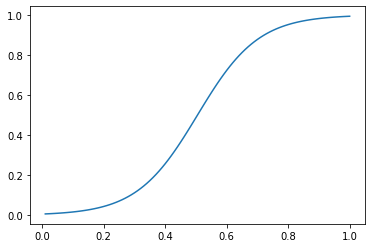

In [47]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [48]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

### Evaluate LSTM

In [49]:
#model_LSTM_bce = torch.load("experiments3/model_LSTM_bce.pth")
#model_LSTM_custom = torch.load("experiments3/model_LSTM_custom.pth")
#model_LSTM_combined = torch.load("experiments3/model_LSTM_combined.pth")

In [50]:
test_batch_size = 4
loss_function = CustomLoss()
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [51]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [52]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

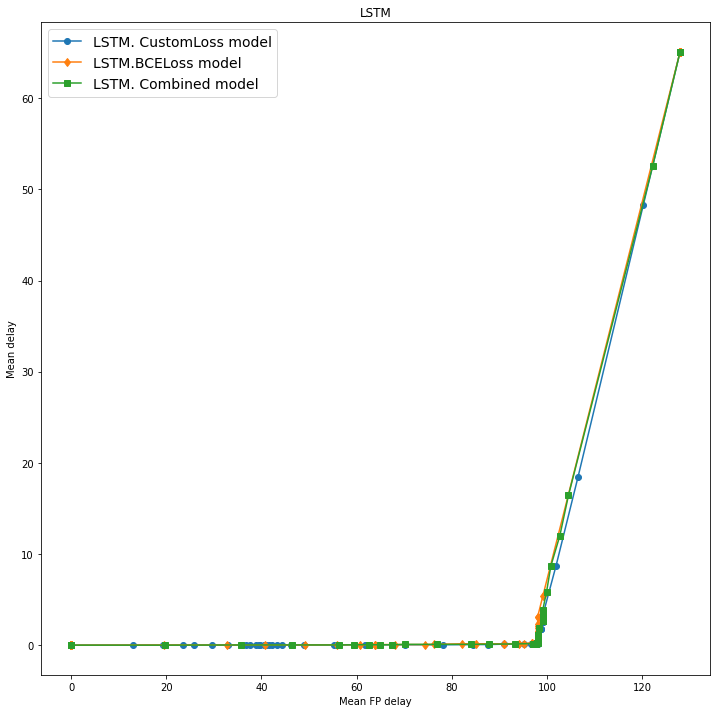

In [53]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', label='LSTM.BCELoss model')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '-s', label='LSTM. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('LSTM')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

In [54]:
#batch, labels = next(iter(val_loader))
#batch = batch.to(device)

In [55]:
#model_LSTM_bce.to(device)

In [56]:
#hidden = model_LSTM_bce.init_hidden(16)
#hidden = tuple([each.data for each in hidden])
#pred = model_LSTM_custom(batch, hidden)

In [57]:
#i = 2
#plt.plot(pred[0][i].detach().cpu().numpy())
#plt.plot(labels[i])

### Evaluate GRU

In [58]:
#model_GRU_bce = torch.load("experiments3/model_GRU_bce.pth")
#model_GRU_custom = torch.load("experiments3/model_GRU_custom.pth")
#model_GRU_combined = torch.load("experiments3/model_GRU_combined.pth")

In [59]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_bce, fn_number_list_GRU_bce, 
 delay_list_GRU_bce, fp_delay_list_GRU_bce) = get_pareto_metrics_for_threshold(model_GRU_bce, final_test_loader, 
                                                                                 threshold_list, RNN_flag=True)

In [60]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_custom, fn_number_list_GRU_custom, 
 delay_list_GRU_custom, fp_delay_list_GRU_custom) = get_pareto_metrics_for_threshold(model_GRU_custom, final_test_loader, 
                                                                                       threshold_list, RNN_flag=True)

In [61]:
test_batch_size = 4
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_GRU_combined, fn_number_list_GRU_combined, delay_list_GRU_combined, fp_delay_list_GRU_combined) = get_pareto_metrics_for_threshold(model_GRU_combined, final_test_loader, threshold_list, RNN_flag=True)

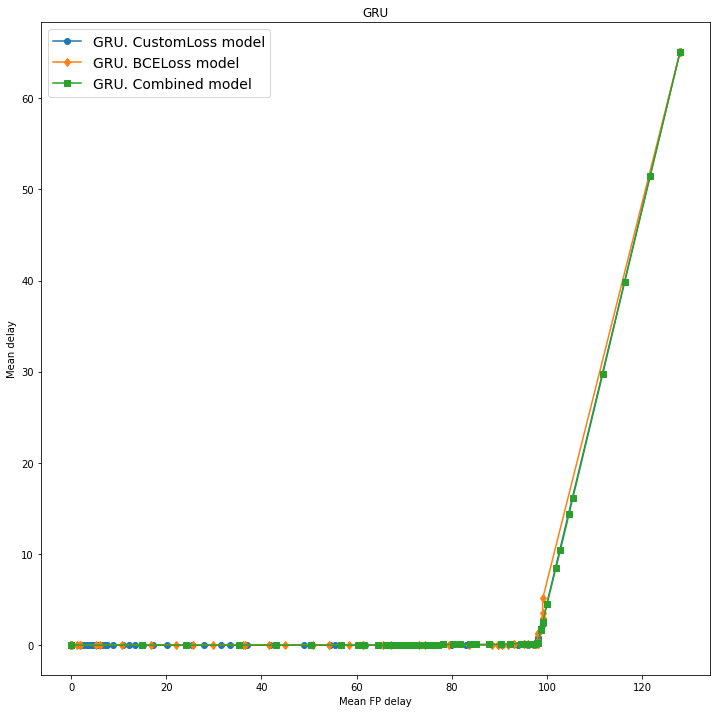

In [62]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_GRU_custom, delay_list_GRU_custom, '-o', label='GRU. CustomLoss model')
plt.plot(fp_delay_list_GRU_bce, delay_list_GRU_bce, '-d', label='GRU. BCELoss model')
plt.plot(fp_delay_list_GRU_combined, delay_list_GRU_combined, '-s', label='GRU. Combined model')

plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.title('GRU')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);

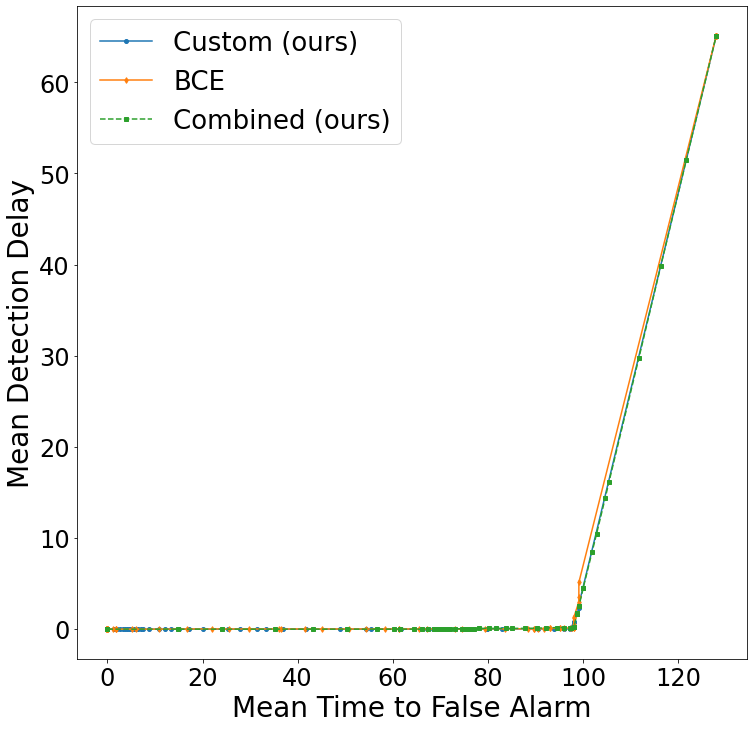

In [65]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_GRU_custom, delay_list_GRU_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_GRU_bce, delay_list_GRU_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_GRU_combined, delay_list_GRU_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('normal1d_GRU.pdf', bbox_inches='tight')

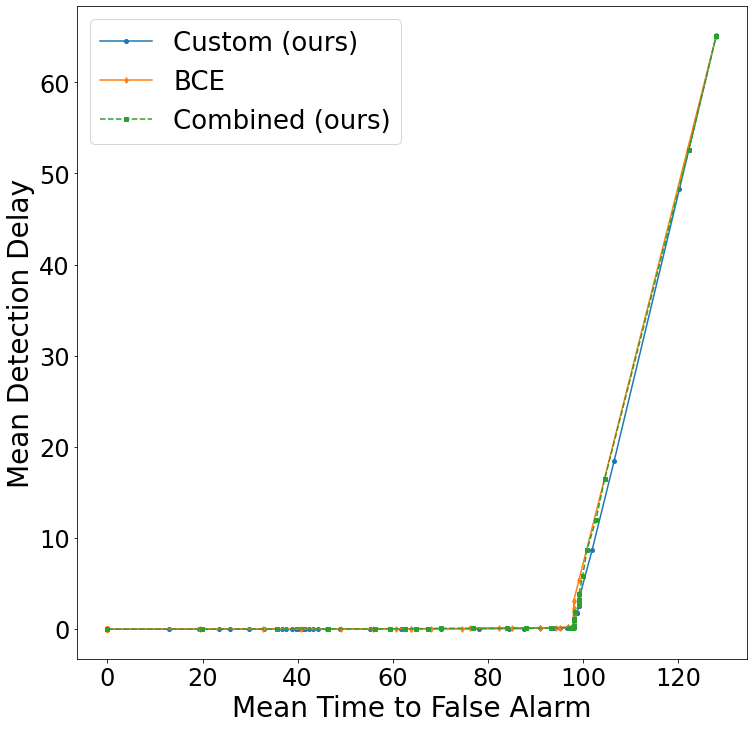

In [64]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', markersize=4, label='Custom (ours)')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', markersize=4, label='BCE')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '--s', markersize=4, label='Combined (ours)')

plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);
plt.savefig('normal1d_LSTM.pdf', bbox_inches='tight')

In [ ]:
 99.14,
 128.0,


In [101]:
fp_delay_list_LSTM_bce.index(99.14)

83

In [102]:
fp_delay_list_LSTM_bce.index(128.0)

84

In [104]:
threshold_list[83]

0.9671956090900572

In [105]:
threshold_list[84]

0.9702535746159258

In [ ]:
k = threshold_list[]

In [ ]:
delay_list_LSTM_bce

In [111]:
%load_ext autoreload
%autoreload 1
%aimport metrics_v4
import metrics_v4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
metrics_v4.save_metrics_to_file_new_version('GRU_custom', 
                                 model_GRU_custom, 
                                 final_test_loader, 
                                 batch_size=4,
                                 seq_len=128,
                                 fp_delay = fp_delay_list_GRU_custom,
                                 threshold_list=threshold_list,
                                 x_coord_arr = [90.05, 95.01, 99, 105.01, 110.01],
                                 lstm_flag=False,
                                 rnn_flag=True,
                                 path_to_save='experiments3/'
                                 )

83.03 0.43720204630561754 90.62 0.462193510926849 90.05
TP: 43 TN: 43 FP: 14 FN: 0 DELAY: 0.01 FP_DELAY 90.62
0.01 !!!!!!!!
93.99 0.4873764205699251 96.07 0.512623579430075 95.01
TP: 45 TN: 49 FP: 6 FN: 0 DELAY: 0.01 FP_DELAY 94.78
0.01 !!!!!!!!
98.79 0.6808271732785297 99.14 0.7023651150255775 99
TP: 44 TN: 54 FP: 0 FN: 2 DELAY: 1.08 FP_DELAY 99.14
1.08 !!!!!!!!
99.14 0.7023651150255775 99.14 0.7230409022118411 105.01
TP: 0 TN: 54 FP: 0 FN: 46 DELAY: 29.93 FP_DELAY 128.0
29.93 !!!!!!!!
99.14 0.7023651150255775 99.14 0.7230409022118411 110.01
TP: 0 TN: 54 FP: 0 FN: 46 DELAY: 29.93 FP_DELAY 128.0
29.93 !!!!!!!!


In [109]:
print('LSTM_custom: ', metrics_v4.area_under_graph(delay_list_LSTM_custom, fp_delay_list_LSTM_custom))
print('LSTM_bce: ', metrics_v4.area_under_graph(delay_list_LSTM_bce, fp_delay_list_LSTM_bce))
print('LSTM_combined: ', metrics_v4.area_under_graph(delay_list_LSTM_combined, fp_delay_list_LSTM_combined)) 

print('\n')

print('GRU_custom: ', metrics_v4.area_under_graph(delay_list_GRU_custom, fp_delay_list_GRU_custom))
print('GRU_bce: ', metrics_v4.area_under_graph(delay_list_GRU_bce, fp_delay_list_GRU_bce))
print('GRU_combined: ', metrics_v4.area_under_graph(delay_list_GRU_combined, fp_delay_list_GRU_combined))  

LSTM_custom:  979.5720652173914
LSTM_bce:  1026.257065217391
LSTM_combined:  1011.0443478260871


GRU_custom:  980.0255434782608
GRU_bce:  1017.9381521739128
GRU_combined:  978.1159782608696
